# Beta versions of the File reader scripts and ratio finder scripts 

In [1]:
def getPDF(Network,Station,location,channel,starttime,endtime):
    import requests

    NEWURL = f"""http://service.iris.edu/mustang/noise-pdf/1/query?net={Network}&sta={Station}&loc={location}&cha={channel}&quality=
    M&starttime={starttime}&endtime={endtime}&format=text&nodata=404"""
    
    response = requests.get(NEWURL)
    
    if '*' in location:
        file = open(f'{Network+Station+channel}M', "wb")
        file.write(response.content)
        file.close()
    else:
        file = open(f'{Network+Station+location+channel}M', "wb")
        file.write(response.content)
        file.close()
    
    return file,starttime,endtime

def file_request():
    Network = input('Please enter Dam network: ')
    Station = input('Please enter station ID (ex: EACA): ')
    location = input('Enter location ID: ')
    channel = input('Please enter Channel ID (ex: HH1): ')
    starttime = input('pplease enter the start date. Enter in yyyy-mm-dd format: ')
    endtime = input('Please enter the desired end date')
    file,starttime,endtime = getPDF(Network,Station,location,channel,starttime,endtime)
    return file,starttime,endtime

# file,startime,endtime = file_request()

In [2]:
#Establish a function that reads a text file from the Mustang Service
def Mustang_text_reader(file = False,starttime = False, endtime = False):
        '''Text Files from the Mustang URL builder can be converted into pandas dataframes. However, they need to be edited
        first so that they can have the proper format for conversion. This function Takes care of the neccessary editing and
        returns a properly formatted dataframe'''
        import pandas as pd
        import os
        if file:
            old_file_name = file.name
            new_file_name = file.name+'new'
            with open(old_file_name) as old_file, open(new_file_name, 'w') as new_file:
            #Loop through the first four lines of the old text file, and record the listed start and end times
                for i, line in enumerate(old_file):
                    if i < 4:
                        if i == 1:
                            start = line
                        if i == 2:
                            end = line
                        continue
                    #Write the remaining data lines to the new text file
                    new_file.write(line)
            #Open the newly written text file and read it in as a pandas dataframe. Title the index column with the start 
            #and end times.
            new_df = open(new_file_name)
            df = pd.read_csv(new_df)
            timestamp = 'start: '+starttime+' end: '+endtime
            df.index.name = timestamp
            #Close the new text file
            new_file.close()
            #Prompt the user if they would like to keep the original text file they inputted
            prompt = input(f'Would you like to keep the original, unedited text file for {old_file_name}? (y/n): ')
            if prompt == 'n':
                os.remove(old_file_name)
            #Return the dataframe
            return(df,timestamp)
         
        elif file == False:
            #Make variables reprenting the inputted (old) filename by calling file request and the future (new) filename
            old_file_io,starttime,endtime = file_request()
            old_file_name = old_file_io.name
            new_file_name = old_file_name+'new'
            #Open the old and new files (opening the new is creating a new file)
            with open(old_file_name) as old_file, open(new_file_name, 'w') as new_file:
                #Loop through the first four lines of the old text file, and record the listed start and end times
                for i, line in enumerate(old_file):
                    if i < 4:
                        if i == 1:
                            start = line
                        if i == 2:
                            end = line
                        continue
                    #Write the remaining data lines to the new text file
                    new_file.write(line)
            #Open the newly written text file and read it in as a pandas dataframe. Title the index column with the start 
            #and end times.
            new_df = open(new_file_name)
            df = pd.read_csv(new_df)
            timestamp = 'start: '+starttime+' end: '+endtime
            df.index.name = timestamp
            #Close the new text file
            new_file.close()
            #Prompt the user if they would like to keep the original text file they inputted
            prompt = input(f'Would you like to keep the original, unedited text file for {old_file_name}? (y/n): ')
            if prompt == 'n':
                os.remove(old_file_name)
            #Return the dataframe
            return(df,timestamp)

# df,timestamp = Mustang_text_reader()
# df

In [3]:
def mustang_station_comparison_reader():
    loc1 = input('Please enter 1st station ID: ')
    loc2 = input('Please enter 2nd Station ID ')
    start = input('Please enter first recording time: ')
    end = input('Please enter second recording time: ')
    dicloc1 = dict()
    dicloc2 = dict()
    for i in range(1,4):
        if i == 3:
            file,starttime,endtime = getPDF('RE',loc1,'*',f'HHZ',start,end)
            df,timestamp = Mustang_text_reader(file,starttime,endtime)
            dicloc1['HHZ'] = (df,timestamp)
        else:
            file,starttime,endtime = getPDF('RE',loc1,'*',f'HH{i}',start,end)
            df,timestamp = Mustang_text_reader(file,starttime,endtime)
            dicloc1[f'HH{i}'] = (df,timestamp)
    for i in range(1,4):
        if i == 3:
            file,starttime,endtime = getPDF('RE',loc2,'*',f'HHZ',start,end)
            df,timestamp = Mustang_text_reader(file,starttime,endtime)
            dicloc2['HHZ'] = (df,timestamp)
        else:
            file,starttime,endtime = getPDF('RE',loc2,'*',f'HH{i}',start,end)
            df,timestamp = Mustang_text_reader(file,starttime,endtime)
            dicloc2[f'HH{i}'] = (df,timestamp)
    return(dicloc1,dicloc2)

dicloc1,dicloc2 = mustang_station_comparison_reader()


KeyboardInterrupt: Interrupted by user

In [ ]:
def spectral_ratio_finder(dicloc1,dicloc2):
    import numpy as np
    ratio_dic = dict()
    for channel in dicloc1:
        powerarrloc1 = np.array(dicloc1[channel][0][' power(db)'])
        powerarrloc2 = np.array(dicloc2[channel][0][' power(db)'])
        if len(powerarrloc1) < len(powerarrloc2):
            diff = len(powerarrloc2) - len(powerarrloc1)
            powerarrloc2 = powerarrloc2[0:len(powerarrloc2)-diff] 
        elif len(powerarrloc2) < len(powerarrloc1):
            diff = len(powerarrloc1) - len(powerarrloc2)
            powerarrloc1 = powerarrloc1[0:len(powerarrloc1)-diff] 
        pmag1 = (10**(powerarrloc1/10))
        pmag2 = (10**(powerarrloc2/10))
        ratio = pmag1/pmag2
        ratio_dic[channel] = (ratio,dicloc1[channel][1])
    return(ratio_dic)

ratio = spectral_ratio_finder(dicloc1,dicloc2) 

ratio['HH1'][0]


In [ ]:
def Mustang_ratio_plotter(ratio_dic,loc1,loc2):
    import matplotlib.pyplot as plt
    fig,ax = plt.subplots(3,1, figsize = (15,15))
    fig.suptitle(f'Spectral Ratio Differences for Sensors from Dam {loc1} and {loc2}', fontsize = 20)
    axes = ax.flatten()
    for i, channel in enumerate(ratio_dic):
        axes[i].plot(ratio[channel][0])
        axes[i].set_title(f'Spectral ratio from channel {channel} for {ratio_dic[channel][1]}')
        axes[i].set_xlabel('Sample #')
        axes[i].set_ylabel('Power magnitude difference, in dB')
#Mustang_ratio_plotter(ratio)    

# Final versions of the file reader + plotter + ratio finder scripts

## Ratio finder without unique frequency detection

In [ ]:
def super_ratio_finder():
    
    def getPDF(Network,Station,location,channel,starttime,endtime):
        import requests

        NEWURL = f"""http://service.iris.edu/mustang/noise-pdf/1/query?net={Network}&sta={Station}&loc={location}&cha={channel}&quality=
        M&starttime={starttime}&endtime={endtime}&format=text&nodata=404"""

        response = requests.get(NEWURL)
        underscore = '_'
        if '*' in location:
            file = open(f'{Network+Station+channel+starttime+underscore+endtime}M', "wb")
            file.write(response.content)
            file.close()
        else:
            file = open(f'{Network+Station+location+channel+starttime+underscore+endtime}M', "wb")
            file.write(response.content)
            file.close()

        return file,starttime,endtime

    def Mustang_text_reader(file = False,starttime = False, endtime = False):
        '''Text Files from the Mustang URL builder can be converted into pandas dataframes. However, they need to be edited
        first so that they can have the proper format for conversion. This function Takes care of the neccessary editing and
        returns a properly formatted dataframe'''
        import pandas as pd
        import os
        if file:
            old_file_name = file.name
            new_file_name = old_file_name+'new'
            with open(old_file_name) as old_file, open(new_file_name, 'w') as new_file:
            #Loop through the first four lines of the old text file, and record the listed start and end times
                for i, line in enumerate(old_file):
                    if i < 4:
                        if i == 1:
                            start = line
                        if i == 2:
                            end = line
                        continue
                    #Write the remaining data lines to the new text file
                    new_file.write(line)
            #Open the newly written text file and read it in as a pandas dataframe. Title the index column with the start 
            #and end times.
            new_df = open(new_file_name)
            df = pd.read_csv(new_df)
            timestamp = 'start: '+starttime+' end: '+endtime
            df.index.name = timestamp
            #Close the new text file
            new_file.close()
            #Remove the old file
            os.remove(old_file_name)
            #Return the dataframe
            return(df,timestamp)
         
        elif file == False:
            #Make variables reprenting the inputted (old) filename by calling file request and the future (new) filename
            old_file_io,starttime,endtime = file_request()
            old_file_name = old_file_io.name
            new_file_name = old_file_name+'new'
            #Open the old and new files (opening the new is creating a new file)
            with os.open(old_file_name) as old_file, os.open(new_file_name, 'w') as new_file:
                #Loop through the first four lines of the old text file, and record the listed start and end times
                for i, line in enumerate(old_file):
                    if i < 4:
                        if i == 1:
                            start = line
                        if i == 2:
                            end = line
                        continue
                    #Write the remaining data lines to the new text file
                    new_file.write(line)
            #Open the newly written text file and read it in as a pandas dataframe. Title the index column with the start 
            #and end times.
            new_df = open(new_file_name)
            df = pd.read_csv(new_df)
            timestamp = 'start: '+starttime+' end: '+endtime
            df.index.name = timestamp
            #Close the new text file
            new_file.close()
            #Prompt the user if they would like to keep the original text file they inputted
            os.remove(old_file_name)
            prompt = input(f'Would you like to keep the newly edited text file for {new_file_name}? (y/n): ')
            if prompt == 'n':
                os.remove(new_file_name)
            #Return the dataframe
            return(df,timestamp)
    def mustang_station_comparison_reader():
        loc1 = input('Please enter 1st station ID: ')
        loc2 = input('Please enter 2nd Station ID ')
        start = input('Please enter first recording time: ')
        end = input('Please enter second recording time: ')
        dicloc1 = dict()
        dicloc2 = dict()
        for i in range(1,4):
            if i == 3:
                file,starttime,endtime = getPDF('RE',loc1,'*',f'HHZ',start,end)
                df,timestamp = Mustang_text_reader(file,starttime,endtime)
                dicloc1['HHZ'] = (df,timestamp)
            else:
                file,starttime,endtime = getPDF('RE',loc1,'*',f'HH{i}',start,end)
                df,timestamp = Mustang_text_reader(file,starttime,endtime)
                dicloc1[f'HH{i}'] = (df,timestamp)
        for i in range(1,4):
            if i == 3:
                file,starttime,endtime = getPDF('RE',loc2,'*',f'HHZ',start,end)
                df,timestamp = Mustang_text_reader(file,starttime,endtime)
                dicloc2['HHZ'] = (df,timestamp)
            else:
                file,starttime,endtime = getPDF('RE',loc2,'*',f'HH{i}',start,end)
                df,timestamp = Mustang_text_reader(file,starttime,endtime)
                dicloc2[f'HH{i}'] = (df,timestamp)
        return(dicloc1,dicloc2,loc1,loc2)

    dicloc1,dicloc2,loc1,loc2 = mustang_station_comparison_reader()
    
    def spectral_ratio_finder(dicloc1,dicloc2):
        import numpy as np
        ratio_dic = dict()
        for channel in dicloc1:
            powerarrloc1 = np.array(dicloc1[channel][0][' power(db)'])
            powerarrloc2 = np.array(dicloc2[channel][0][' power(db)'])
            if len(powerarrloc1) < len(powerarrloc2):
                diff = len(powerarrloc2) - len(powerarrloc1)
                powerarrloc2 = powerarrloc2[0:len(powerarrloc2)-diff] 
            elif len(powerarrloc2) < len(powerarrloc1):
                diff = len(powerarrloc1) - len(powerarrloc2)
                powerarrloc1 = powerarrloc1[0:len(powerarrloc1)-diff] 
            pmag1 = (10**(powerarrloc1/10))
            pmag2 = (10**(powerarrloc2/10))
            ratio = pmag1/pmag2
            ratio_dic[channel] = (ratio,dicloc1[channel][0]['#freq(hz)'],dicloc1[channel][1])
        return(ratio_dic)

    ratio = spectral_ratio_finder(dicloc1,dicloc2) 
    
    def Mustang_ratio_plotter(ratio_dic,loc1,loc2):
        import matplotlib.pyplot as plt
        fig,ax = plt.subplots(3,1, figsize = (17,17))
        plt.subplots_adjust(hspace=0.35)
        fig.suptitle(f"""Spectral Ratio Differences for Crest and Toe sensors from Dams {loc1} and {loc2}
        during {ratio_dic['HH1'][2]}""", fontsize = 20)
        axes = ax.flatten()
        for i, channel in enumerate(ratio_dic):
            freq = ratio_dic[channel][1]
            ratio = ratio_dic[channel][0]
            if len(freq) < len(ratio):
                diff = len(ratio) - len(freq)
                ratio = ratio[0:len(ratio) - diff]
            elif len(ratio) < len(freq):
                diff = len(freq) - len(ratio)
                freq = freq[0:len(freq) - diff]
            axes[i].plot(freq,ratio)
            axes[i].set_title(f'Spectral ratio from channel {channel}',fontsize = 15)
            axes[i].set_xlabel('Frequency, in HZ ',fontsize = 14)
            axes[i].set_ylabel('Power magnitude difference, in dB',fontsize = 13)
            axes[i].set_xscale('log')
            axes[i].set_yscale('log')
            axes[i].set_xlim(0.1,10)

    Mustang_ratio_plotter(ratio,loc1,loc2)
    
    return(dicloc1,dicloc2,ratio)
    

In [ ]:
dicloc1,dicloc2,ratio = super_ratio_finder()

In [ ]:
import pandas as pd
import numpy as np
unique_freq = pd.unique(df['#freq(hz)'])
powers = np.array([])
for freq in unique_freq:
    new_df = df[df['#freq(hz)'] == freq]
    most_hits = new_df.loc[new_df[' hits'].idxmax()]
    powers = np.append(powers,most_hits[1])
    

super_df = pd.DataFrame()
super_df['#freq(hz)'] = unique_freq
super_df[' power(db)'] = powers
super_df.index.name = df.index.name
css = super_df.to_csv('newcsv.csv')


## If you happen to get a 'KEY ERROR: ['FREQ(HZ)']' while running this code, that means there was no data available for the web request you submitted.

## Ratio Finder that factors in unique frequencies and uses the HH channel convention

In [17]:
def super_ratio_finder_HH():
    #Initialize a web-request function for Mustang
    def getPDF(Network,Station,location,channel,starttime,endtime):
        import requests
        #Make a URL variable that will be sent with the web request
        NEWURL = f"""http://service.iris.edu/mustang/noise-pdf/1/query?net={Network}&sta={Station}&loc={location}&cha={channel}&quality=
        M&starttime={starttime}&endtime={endtime}&format=text&nodata=404"""
        #Obtain the data from the web
        response = requests.get(NEWURL)
        underscore = '_'
        #Write the data to a text file and return it along with the startime and endtime values. 
        if '*' in location:
            file = open(f'{Network+Station+channel+starttime+underscore+endtime}M', "wb")
            file.write(response.content)
            file.close()
        else:
            file = open(f'{Network+Station+location+channel+starttime+underscore+endtime}M', "wb")
            file.write(response.content)
            file.close()

        return file,starttime,endtime
    #Optional function that has more specific inputs for data collection. 
    def file_request():
        Network = input('Please enter Dam network: ')
        Station = input('Please enter station ID (ex: EACA): ')
        location = input('Enter location ID: ')
        channel = input('Please enter Channel ID (ex: HH1): ')
        starttime = input('Please enter the start date. Enter in yyyy-mm-dd format: ')
        endtime = input('Please enter the desired end date')
        file,starttime,endtime = getPDF(Network,Station,location,channel,starttime,endtime)
        return file,starttime,endtime

    #Define a function 
    def Mustang_text_reader(file = False,starttime = False, endtime = False):
        '''Text Files from the Mustang URL builder can be converted into pandas dataframes. However, they need to be edited
        first so that they can have the proper format for conversion. This function Takes care of the neccessary editing and
        returns a properly formatted dataframe'''
        import pandas as pd
        import os
        if file:
            old_file_name = file.name
            new_file_name = old_file_name+'new'
            with open(old_file_name) as old_file, open(new_file_name, 'w') as new_file:
            #Loop through the first four lines of the old text file, and write the rest of the lines to a new txt. 
                for i, line in enumerate(old_file):
                    if i < 4:
                        continue
                    #Write the remaining data lines to the new text file
                    new_file.write(line)
            #Open the newly written text file and read it in as a pandas dataframe. Title the index column with the start 
            #and end times.
            new_df = open(new_file_name)
            df = pd.read_csv(new_df)
            timestamp = 'start: '+starttime+' end: '+endtime
            df.index.name = timestamp
            import numpy as np
            # Narrow the original dataframe according to its unique frequencies. 
            unique_freq = pd.unique(df['#freq(hz)'])
            powers = np.array([])
            #Loop through each unique frequency and identify the power value with the strongest occurence (most hits). Keep these powers in an array
            for freq in unique_freq:
                newest_df = df[df['#freq(hz)'] == freq]
                most_hits = newest_df.loc[newest_df[' hits'].idxmax()]
                powers = np.append(powers,most_hits[1])
            #Make a new dataframe with only the unique frequncies and strongest (most-hit) power values 
            super_df = pd.DataFrame()
            super_df['#freq(hz)'] = unique_freq
            super_df[' power(db)'] = powers
            super_df.index.name = df.index.name
            #Close the new text file
            new_file.close()
            #Remove the old file
            os.remove(old_file_name)
            #Return the dataframe
            return(super_df,timestamp)
         
        elif file == False:
            #Make variables reprenting the inputted (old) filename by calling file request and the future (new) filename
            old_file_io,starttime,endtime = file_request()
            old_file_name = old_file_io.name
            new_file_name = old_file_name+'new'
            #Open the old and new files (opening the new is creating a new file)
            with os.open(old_file_name) as old_file, os.open(new_file_name, 'w') as new_file:
                #Skip through the first four lines of the old text file, and write the remaining lines to a new txt 
                for i, line in enumerate(old_file):
                    if i < 4:
                        continue
                    #Write the remaining data lines to the new text file
                    new_file.write(line)
            #Open the newly written text file and read it in as a pandas dataframe. Title the index column with the start 
            #and end times.
            new_df = open(new_file_name)
            df = pd.read_csv(new_df)
            timestamp = 'start: '+starttime+' end: '+endtime
            df.index.name = timestamp
            import numpy as np
            # Narrow the original dataframe according to its unique frequencies. 
            unique_freq = pd.unique(df['#freq(hz)'])
            powers = np.array([])
            #Loop through each unique frequency and identify the power value with the strongest occurence (most hits). Keep these powers in an array
            for freq in unique_freq:
                newest_df = df[df['#freq(hz)'] == freq]
                most_hits = newest_df.loc[newest_df[' hits'].idxmax()]
                powers = np.append(powers,most_hits[1])
            super_df = pd.DataFrame()
            #Make a new dataframe with only the unique frequncies and strongest (most-hit) power values 
            super_df['#freq(hz)'] = unique_freq
            super_df[' power(db)'] = powers
            super_df.index.name = df.index.name
            #Close the new text file
            new_file.close()
            os.remove(old_file_name)
            #Return the dataframe
            return(df,timestamp)
    def mustang_station_comparison_reader():
        #Collect some input inforamtion 
        loc1 = input('Please enter 1st station ID: ')
        loc2 = input('Please enter 2nd Station ID ')
        start = input('Please enter first recording time: ')
        end = input('Please enter second recording time: ')
        #Create two dictionaries that will store the station data
        dicloc1 = dict()
        dicloc2 = dict()
        #Loop through two ranges and collect all data for all channels across the two locations. 
        for i in range(1,4):
            if i == 3:
                file,starttime,endtime = getPDF('RE',loc1,'*',f'HHZ',start,end)
                df,timestamp = Mustang_text_reader(file,starttime,endtime)
                dicloc1['HHZ'] = (df,timestamp)
            else:
                file,starttime,endtime = getPDF('RE',loc1,'*',f'HH{i}',start,end)
                df,timestamp = Mustang_text_reader(file,starttime,endtime)
                dicloc1[f'HH{i}'] = (df,timestamp)
        for i in range(1,4):
            if i == 3:
                file,starttime,endtime = getPDF('RE',loc2,'*',f'HHZ',start,end)
                df,timestamp = Mustang_text_reader(file,starttime,endtime)
                dicloc2['HHZ'] = (df,timestamp)
            else:
                file,starttime,endtime = getPDF('RE',loc2,'*',f'HH{i}',start,end)
                df,timestamp = Mustang_text_reader(file,starttime,endtime)
                dicloc2[f'HH{i}'] = (df,timestamp)
        return(dicloc1,dicloc2,loc1,loc2,starttime,endtime)

    dicloc1,dicloc2,loc1,loc2,starttime,endtime = mustang_station_comparison_reader()
    
    def spectral_ratio_finder(dicloc1,dicloc2):
        import numpy as np
        #Initialize a dictionary that will store all the ratio data
        ratio_dic = dict()
        for channel in dicloc1:
            #Create arrays from the power data within the location dictionaries. 
            powerarrloc1 = np.array(dicloc1[channel][0][' power(db)'])
            powerarrloc2 = np.array(dicloc2[channel][0][' power(db)'])
            #Sometimes power data will be different between channels. To accomdoate the calculations, we'll have to truncate the data from the largest array. 
            if len(powerarrloc1) < len(powerarrloc2):
                diff = len(powerarrloc2) - len(powerarrloc1)
                powerarrloc2 = powerarrloc2[0:len(powerarrloc2)-diff] 
            elif len(powerarrloc2) < len(powerarrloc1):
                diff = len(powerarrloc1) - len(powerarrloc2)
                powerarrloc1 = powerarrloc1[0:len(powerarrloc1)-diff] 
            #Calculate the power magnitude of the two arrays
            pmag1 = (10**(powerarrloc1/10))
            pmag2 = (10**(powerarrloc2/10))
            #Calculate the spectral ratio and inserr it into the dictionary
            ratio = pmag1/pmag2
            ratio_dic[channel] = (ratio,dicloc1[channel][0]['#freq(hz)'],dicloc1[channel][1])
        return(ratio_dic)

    ratio = spectral_ratio_finder(dicloc1,dicloc2) 
    
    def Mustang_ratio_plotter(ratio_dic,loc1,loc2):
        import matplotlib.pyplot as plt
        #Etablish a figure with three subplots and title it 
        fig,ax = plt.subplots(3,1, figsize = (6.5,6.5))
        plt.subplots_adjust(hspace=0.5)
        fig.suptitle(f"""Spectral Ratio Differences for Crest and Toe sensors from Dam sensors {loc1} and {loc2}
        during {ratio_dic['HH1'][2]}""", fontsize = 10)
        axes = ax.flatten()
        #Loop through the ratio dictionary
        for i, channel in enumerate(ratio_dic):
            #We ecnounter the same issue as before with unmatched lengths of the ratio/frequency arrays. Repeat the truncation convention for the largest array
            freq = ratio_dic[channel][1]
            ratio = ratio_dic[channel][0]
            if len(freq) < len(ratio):
                diff = len(ratio) - len(freq)
                ratio = ratio[0:len(ratio) - diff]
            elif len(ratio) < len(freq):
                diff = len(freq) - len(ratio)
                freq = freq[0:len(freq) - diff]
            #Plot a log-scale graph of the ratios
            axes[i].plot(freq,ratio)
            axes[i].set_title(f'Spectral ratio from channel {channel}',fontsize = 8)
            axes[i].set_xlabel('Frequency, in HZ ',fontsize = 7)
            axes[i].set_ylabel('Power magnitude ratio',fontsize = 7)
            axes[i].set_xscale('log')
            axes[i].set_yscale('log')
            axes[i].set_xlim(0.1,10)
            
    Mustang_ratio_plotter(ratio,loc1,loc2)
    #Export the ratio data to CSV files 
    import pandas as pd
    for i in range(1,4):
        if i == 3:
            new_csv = pd.DataFrame()
            new_csv['frequency (hz)'] = ratio['HHZ'][1]
            new_csv['ratio'] = ratio['HHZ'][0]
            new_csv.to_csv(f"{loc1}_{loc2}_{starttime}_{endtime}_channel_HHZ_ratio_data.csv")
        else:
            new_csv = pd.DataFrame()
            new_csv['frequency (hz)'] = ratio[f'HH{i}'][1]
            new_csv['ratio'] = ratio[f'HH{i}'][0]
            new_csv.to_csv(f'{loc1}_{loc2}_{starttime}_{endtime}_channel_HH{i}_ratio_data.csv')
    
    return(dicloc1,dicloc2,ratio)
    

Please enter 1st station ID:  JRDN
Please enter 2nd Station ID  JRDN1
Please enter first recording time:  2020-06-25
Please enter second recording time:  2020-06-26


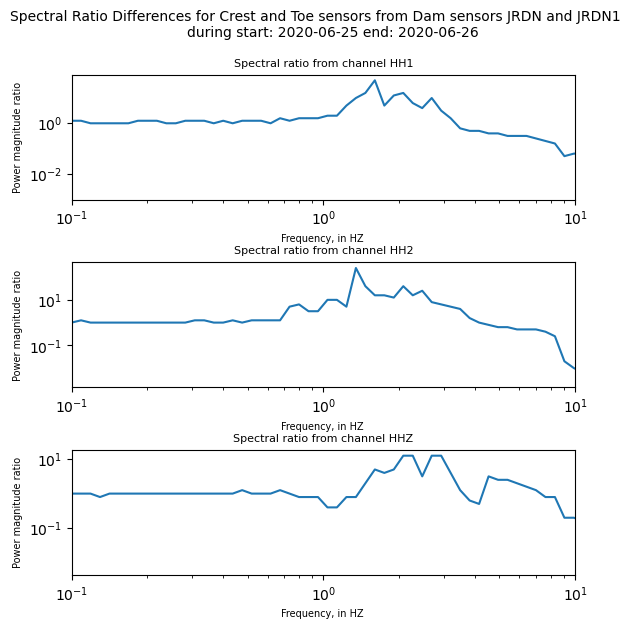

In [18]:
dicloc1,dicloc2,ratio = super_ratio_finder_HH()

## The Following Functions are quite similar to the HH conventions. Refer to the comments above for explanations on the code.

## Ratio Finder that factors in unique frequencies and uses the HN channel convention

In [37]:
def super_ratio_finder_HN():
    
    def getPDF(Network,Station,location,channel,starttime,endtime):
        import requests

        NEWURL = f"""http://service.iris.edu/mustang/noise-pdf/1/query?net={Network}&sta={Station}&loc={location}&cha={channel}&quality=
        M&starttime={starttime}&endtime={endtime}&format=text&nodata=404"""

        response = requests.get(NEWURL)
        underscore = '_'
        if '*' in location:
            file = open(f'{Network+Station+channel+starttime+underscore+endtime}M', "wb")
            file.write(response.content)
            file.close()
        else:
            file = open(f'{Network+Station+location+channel+starttime+underscore+endtime}M', "wb")
            file.write(response.content)
            file.close()

        return file,starttime,endtime

    def file_request():
        Network = input('Please enter Dam network: ')
        Station = input('Please enter station ID (ex: EACA): ')
        location = input('Enter location ID: ')
        channel = input('Please enter Channel ID (ex: HH1): ')
        starttime = input('pplease enter the start date. Enter in yyyy-mm-dd format: ')
        endtime = input('Please enter the desired end date')
        file,starttime,endtime = getPDF(Network,Station,location,channel,starttime,endtime)
        return file,starttime,endtime

    def Mustang_text_reader(file = False,starttime = False, endtime = False):
        '''Text Files from the Mustang URL builder can be converted into pandas dataframes. However, they need to be edited
        first so that they can have the proper format for conversion. This function Takes care of the neccessary editing and
        returns a properly formatted dataframe'''
        import pandas as pd
        import os
        if file:
            old_file_name = file.name
            new_file_name = old_file_name+'new'
            with open(old_file_name) as old_file, open(new_file_name, 'w') as new_file:
            #Skip through the first four lines of the old text file, and write the remaining lines to a new txt 
                for i, line in enumerate(old_file):
                    if i < 4:
                        continue
                    #Write the remaining data lines to the new text file
                    new_file.write(line)
            #Open the newly written text file and read it in as a pandas dataframe. Title the index column with the start 
            #and end times.
            new_df = open(new_file_name)
            df = pd.read_csv(new_df)
            timestamp = 'start: '+starttime+' end: '+endtime
            df.index.name = timestamp
            import numpy as np
            unique_freq = pd.unique(df['#freq(hz)'])
            powers = np.array([])
            for freq in unique_freq:
                newest_df = df[df['#freq(hz)'] == freq]
                most_hits = newest_df.loc[newest_df[' hits'].idxmax()]
                powers = np.append(powers,most_hits[1])
            super_df = pd.DataFrame()
            super_df['#freq(hz)'] = unique_freq
            super_df[' power(db)'] = powers
            super_df.index.name = df.index.name
            #Close the new text file
            new_file.close()
            #Remove the old file
            os.remove(old_file_name)
            #Return the dataframe
            return(super_df,timestamp)
         
        elif file == False:
            #Make variables reprenting the inputted (old) filename by calling file request and the future (new) filename
            old_file_io,starttime,endtime = file_request()
            old_file_name = old_file_io.name
            new_file_name = old_file_name+'new'
            #Open the old and new files (opening the new is creating a new file)
            with os.open(old_file_name) as old_file, os.open(new_file_name, 'w') as new_file:
                #Skip through the first four lines of the old text file, and write the remaining lines to a new txt 
                for i, line in enumerate(old_file):
                    if i < 4:
                        continue
                    #Write the remaining data lines to the new text file
                    new_file.write(line)
            #Open the newly written text file and read it in as a pandas dataframe. Title the index column with the start 
            #and end times.
            new_df = open(new_file_name)
            df = pd.read_csv(new_df)
            timestamp = 'start: '+starttime+' end: '+endtime
            df.index.name = timestamp
            import numpy as np
            unique_freq = pd.unique(df['#freq(hz)'])
            powers = np.array([])
            for freq in unique_freq:
                newest_df = df[df['#freq(hz)'] == freq]
                most_hits = newest_df.loc[newest_df[' hits'].idxmax()]
                powers = np.append(powers,most_hits[1])
            super_df = pd.DataFrame()
            super_df['#freq(hz)'] = unique_freq
            super_df[' power(db)'] = powers
            super_df.index.name = df.index.name
            #Close the new text file
            new_file.close()
            os.remove(old_file_name)
            #Return the dataframe
            return(df,timestamp)
    def mustang_station_comparison_reader():
        loc1 = input('Please enter 1st station ID: ')
        loc2 = input('Please enter 2nd Station ID ')
        start = input('Please enter first recording time: ')
        end = input('Please enter second recording time: ')
        dicloc1 = dict()
        dicloc2 = dict()
        for i in range(1,4):
            if i == 3:
                file,starttime,endtime = getPDF('RE',loc1,'*',f'HNZ',start,end)
                df,timestamp = Mustang_text_reader(file,starttime,endtime)
                dicloc1['HNZ'] = (df,timestamp)
            else:
                file,starttime,endtime = getPDF('RE',loc1,'*',f'HN{i}',start,end)
                df,timestamp = Mustang_text_reader(file,starttime,endtime)
                dicloc1[f'HN{i}'] = (df,timestamp)
        for i in range(1,4):
            if i == 3:
                file,starttime,endtime = getPDF('RE',loc2,'*',f'HNZ',start,end)
                df,timestamp = Mustang_text_reader(file,starttime,endtime)
                dicloc2['HNZ'] = (df,timestamp)
            else:
                file,starttime,endtime = getPDF('RE',loc2,'*',f'HN{i}',start,end)
                df,timestamp = Mustang_text_reader(file,starttime,endtime)
                dicloc2[f'HN{i}'] = (df,timestamp)
        return(dicloc1,dicloc2,loc1,loc2,starttime,endtime)

    dicloc1,dicloc2,loc1,loc2,starttime,endtime = mustang_station_comparison_reader()
    
    def spectral_ratio_finder(dicloc1,dicloc2):
        import numpy as np
        ratio_dic = dict()
        for channel in dicloc1:
            powerarrloc1 = np.array(dicloc1[channel][0][' power(db)'])
            powerarrloc2 = np.array(dicloc2[channel][0][' power(db)'])
            if len(powerarrloc1) < len(powerarrloc2):
                diff = len(powerarrloc2) - len(powerarrloc1)
                powerarrloc2 = powerarrloc2[0:len(powerarrloc2)-diff] 
            elif len(powerarrloc2) < len(powerarrloc1):
                diff = len(powerarrloc1) - len(powerarrloc2)
                powerarrloc1 = powerarrloc1[0:len(powerarrloc1)-diff] 
            pmag1 = (10**(powerarrloc1/10))
            pmag2 = (10**(powerarrloc2/10))
            ratio = pmag1/pmag2
            ratio_dic[channel] = (ratio,dicloc1[channel][0]['#freq(hz)'],dicloc1[channel][1])
        return(ratio_dic)

    ratio = spectral_ratio_finder(dicloc1,dicloc2) 
    
    def Mustang_ratio_plotter(ratio_dic,loc1,loc2):
        import matplotlib.pyplot as plt
        fig,ax = plt.subplots(3,1, figsize = (17,17))
        plt.subplots_adjust(hspace=0.35)
        fig.suptitle(f"""Spectral Ratio Differences for Crest and Toe sensors from Dam sensors {loc1} and {loc2}
        during {ratio_dic['HN1'][2]}""", fontsize = 20)
        axes = ax.flatten()
        for i, channel in enumerate(ratio_dic):
            freq = ratio_dic[channel][1]
            ratio = ratio_dic[channel][0]
            if len(freq) < len(ratio):
                diff = len(ratio) - len(freq)
                ratio = ratio[0:len(ratio) - diff]
            elif len(ratio) < len(freq):
                diff = len(freq) - len(ratio)
                freq = freq[0:len(freq) - diff]
            axes[i].plot(freq,ratio)
            axes[i].set_title(f'Spectral ratio from channel {channel}',fontsize = 15)
            axes[i].set_xlabel('Frequency, in HZ ',fontsize = 14)
            axes[i].set_ylabel('Power magnitude ratio',fontsize = 13)
            axes[i].set_xscale('log')
            axes[i].set_yscale('log')
            axes[i].set_xlim(0.1,10)
            
    Mustang_ratio_plotter(ratio,loc1,loc2)
    import pandas as pd
    for i in range(1,4):
        if i == 3:
            new_csv = pd.DataFrame()
            new_csv['frequency (hz)'] = ratio['HNZ'][1]
            new_csv['ratio'] = ratio['HNZ'][0]
            new_csv.to_csv(f"{loc1}_{starttime}_{endtime}_channel_HNZ_ratio_data.csv")
        else:
            new_csv = pd.DataFrame()
            new_csv['frequency (hz)'] = ratio[f'HN{i}'][1]
            new_csv['ratio'] = ratio[f'HN{i}'][0]
            new_csv.to_csv(f'{loc1}_{starttime}_{endtime}_channel_HN{i}_ratio_data.csv')
    
    
    return(dicloc1,dicloc2,ratio)

Please enter 1st station ID:  JKLK
Please enter 2nd Station ID  JKLK1
Please enter first recording time:  2020-06-23
Please enter second recording time:  2020-06-24


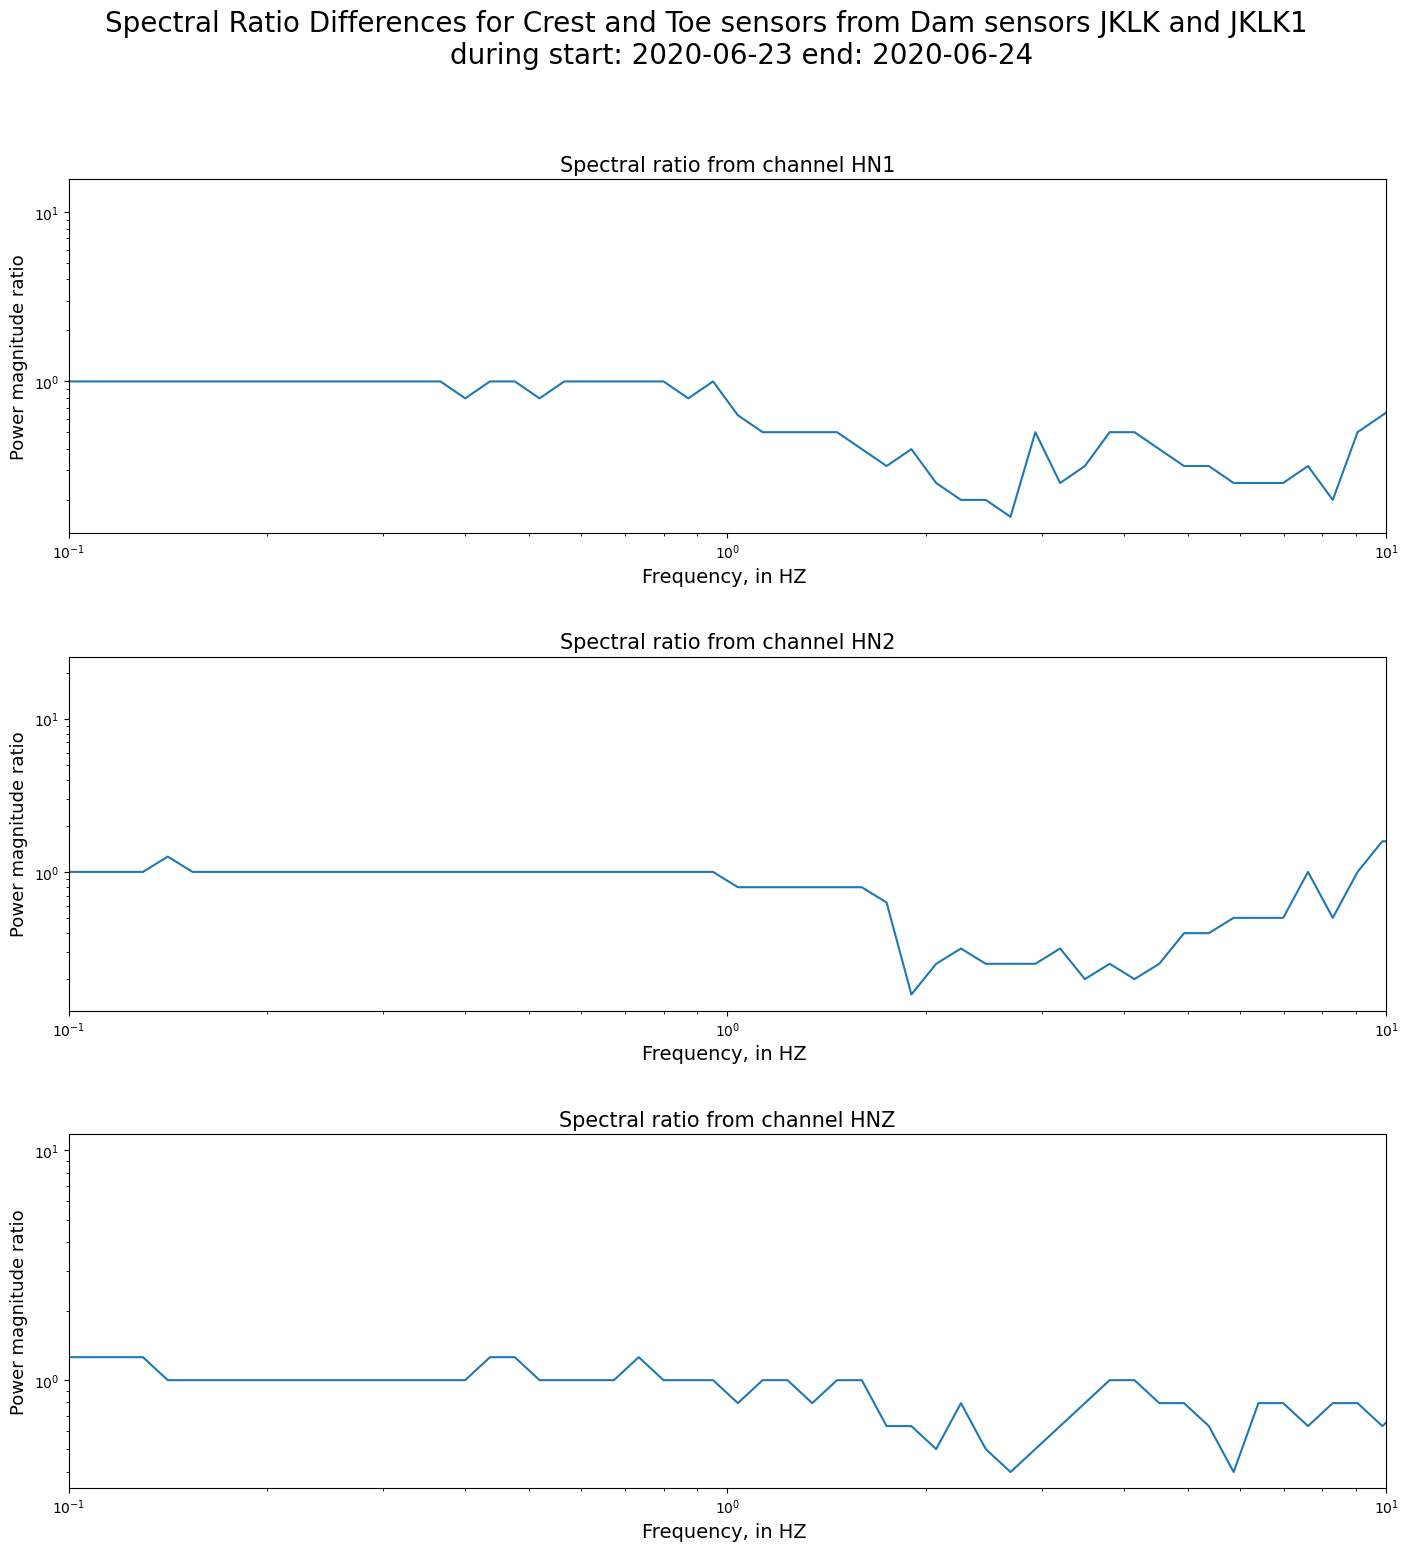

In [39]:
dicloc1,dicloc2,ratio = super_ratio_finder_HN()

## Ratio Finder that factors in unique frequencies and operates on location differentiation between 33 and 23

In [27]:
def super_ratio_finder_loc_33_23():
    
    def getPDF(Network,Station,location,channel,starttime,endtime):
        import requests

        NEWURL = f"""http://service.iris.edu/mustang/noise-pdf/1/query?net={Network}&sta={Station}&loc={location}&cha={channel}&quality=
        M&starttime={starttime}&endtime={endtime}&format=text&nodata=404"""

        response = requests.get(NEWURL)
        underscore = '_'
        if '*' in location:
            file = open(f'{Network+Station+channel+starttime+underscore+endtime}M', "wb")
            file.write(response.content)
            file.close()
        else:
            file = open(f'{Network+Station+location+channel+starttime+underscore+endtime}M', "wb")
            file.write(response.content)
            file.close()

        return file,starttime,endtime

    def file_request():
        Network = input('Please enter Dam network: ')
        Station = input('Please enter station ID (ex: EACA): ')
        location = input('Enter location ID: ')
        channel = input('Please enter Channel ID (ex: HH1): ')
        starttime = input('please enter the start date. Enter in yyyy-mm-dd format: ')
        endtime = input('Please enter the desired end date')
        file,starttime,endtime = getPDF(Network,Station,location,channel,starttime,endtime)
        return file,starttime,endtime

    def Mustang_text_reader(file = False,starttime = False, endtime = False):
        '''Text Files from the Mustang URL builder can be converted into pandas dataframes. However, they need to be edited
        first so that they can have the proper format for conversion. This function Takes care of the neccessary editing and
        returns a properly formatted dataframe'''
        import pandas as pd
        import os
        if file:
            old_file_name = file.name
            new_file_name = old_file_name+'new'
            with open(old_file_name) as old_file, open(new_file_name, 'w') as new_file:
            #Skip through the first four lines of the old text file, and write the remaining lines to a new txt 
                for i, line in enumerate(old_file):
                    if i < 4:
                        continue
                    #Write the remaining data lines to the new text file
                    new_file.write(line)
            #Open the newly written text file and read it in as a pandas dataframe. Title the index column with the start 
            #and end times.
            new_df = open(new_file_name)
            df = pd.read_csv(new_df)
            timestamp = 'start: '+starttime+' end: '+endtime
            df.index.name = timestamp
            import numpy as np
            unique_freq = pd.unique(df['#freq(hz)'])
            powers = np.array([])
            for freq in unique_freq:
                newest_df = df[df['#freq(hz)'] == freq]
                most_hits = newest_df.loc[newest_df[' hits'].idxmax()]
                powers = np.append(powers,most_hits[1])
            super_df = pd.DataFrame()
            super_df['#freq(hz)'] = unique_freq
            super_df[' power(db)'] = powers
            super_df.index.name = df.index.name
            #Close the new text file
            new_file.close()
            #Remove the old file
            os.remove(old_file_name)
            #Return the dataframe
            return(super_df,timestamp)
         
        elif file == False:
            #Make variables reprenting the inputted (old) filename by calling file request and the future (new) filename
            old_file_io,starttime,endtime = file_request()
            old_file_name = old_file_io.name
            new_file_name = old_file_name+'new'
            #Open the old and new files (opening the new is creating a new file)
            with os.open(old_file_name) as old_file, os.open(new_file_name, 'w') as new_file:
            #Skip through the first four lines of the old text file, and write the remaining lines to a new txt 
                for i, line in enumerate(old_file):
                    if i < 4:
                        continue
                    #Write the remaining data lines to the new text file
                    new_file.write(line)
            #Open the newly written text file and read it in as a pandas dataframe. Title the index column with the start 
            #and end times.
            new_df = open(new_file_name)
            df = pd.read_csv(new_df)
            timestamp = 'start: '+starttime+' end: '+endtime
            df.index.name = timestamp
            import numpy as np
            unique_freq = pd.unique(df['#freq(hz)'])
            powers = np.array([])
            for freq in unique_freq:
                newest_df = df[df['#freq(hz)'] == freq]
                most_hits = newest_df.loc[newest_df[' hits'].idxmax()]
                powers = np.append(powers,most_hits[1])
            super_df = pd.DataFrame()
            super_df['#freq(hz)'] = unique_freq
            super_df[' power(db)'] = powers
            super_df.index.name = df.index.name
            #Close the new text file
            new_file.close()
            os.remove(old_file_name)
            #Return the dataframe
            return(df,timestamp)
    def mustang_station_comparison_reader():
        loc = input('Please enter 1st station ID: ')
        start = input('Please enter first recording time: ')
        end = input('Please enter second recording time: ')
        dicloc23 = dict()
        dicloc33 = dict()
        for i in range(1,4):
            if i == 3:
                file,starttime,endtime = getPDF('RE',loc,'23','HNZ',start,end)
                df,timestamp = Mustang_text_reader(file,starttime,endtime)
                dicloc23['HNZ'] = (df,timestamp)
            else:
                file,starttime,endtime = getPDF('RE',loc,'23',f'HN{i}',start,end)
                df,timestamp = Mustang_text_reader(file,starttime,endtime)
                dicloc23[f'HN{i}'] = (df,timestamp)
        for i in range(1,4):
            if i == 3:
                file,starttime,endtime = getPDF('RE',loc,'33','HNZ',start,end)
                df,timestamp = Mustang_text_reader(file,starttime,endtime)
                dicloc33['HNZ'] = (df,timestamp)
            else:
                file,starttime,endtime = getPDF('RE',loc,'33',f'HN{i}',start,end)
                df,timestamp = Mustang_text_reader(file,starttime,endtime)
                dicloc33[f'HN{i}'] = (df,timestamp)
        return(dicloc23,dicloc33,loc,starttime,endtime)

    dicloc23,dicloc33,loc,starttime,endtime = mustang_station_comparison_reader()
    
    def spectral_ratio_finder(dicloc33,dicloc23):
        import numpy as np
        ratio_dic = dict()
        for channel in dicloc33:
            powerarrloc1 = np.array(dicloc33[channel][0][' power(db)'])
            powerarrloc2 = np.array(dicloc23[channel][0][' power(db)'])
            if len(powerarrloc1) < len(powerarrloc2):
                diff = len(powerarrloc2) - len(powerarrloc1)
                powerarrloc2 = powerarrloc2[0:len(powerarrloc2)-diff] 
            elif len(powerarrloc2) < len(powerarrloc1):
                diff = len(powerarrloc1) - len(powerarrloc2)
                powerarrloc1 = powerarrloc1[0:len(powerarrloc1)-diff] 
            pmag1 = (10**(powerarrloc1/10))
            pmag2 = (10**(powerarrloc2/10))
            ratio = pmag1/pmag2
            ratio_dic[channel] = (ratio,dicloc33[channel][0]['#freq(hz)'],dicloc33[channel][1])
        return(ratio_dic)

    ratio = spectral_ratio_finder(dicloc33,dicloc23) 
    
    def Mustang_ratio_plotter(ratio_dic,loc):
        import matplotlib.pyplot as plt
        fig,ax = plt.subplots(3,1, figsize = (17,17))
        plt.subplots_adjust(hspace=0.35)
        fig.suptitle(f"""Spectral Ratio Differences for Crest and Toe sensors from Dam sensors {loc} 33 and {loc} 23
        during {ratio_dic['HN1'][2]}""", fontsize = 20)
        axes = ax.flatten()
        for i, channel in enumerate(ratio_dic):
            freq = ratio_dic[channel][1]
            ratio = ratio_dic[channel][0]
            if len(freq) < len(ratio):
                diff = len(ratio) - len(freq)
                ratio = ratio[0:len(ratio) - diff]
            elif len(ratio) < len(freq):
                diff = len(freq) - len(ratio)
                freq = freq[0:len(freq) - diff]
            axes[i].plot(freq,ratio)
            axes[i].set_title(f'Spectral ratio from channel {channel}',fontsize = 15)
            axes[i].set_xlabel('Frequency, in HZ ',fontsize = 14)
            axes[i].set_ylabel('Power magnitude ratio',fontsize = 13)
            axes[i].set_xscale('log')
            axes[i].set_yscale('log')
            axes[i].set_xlim(0.1,10)
            
    Mustang_ratio_plotter(ratio,loc)
    import pandas as pd
    for i in range(1,4):
        if i == 3:
            new_csv = pd.DataFrame()
            new_csv['frequency (hz)'] = ratio['HNZ'][1]
            new_csv['ratio'] = ratio['HNZ'][0]
            new_csv.to_csv(f"{loc}_{starttime}_{endtime}_channel_HNZ_ratio_data.csv")
        else:
            new_csv = pd.DataFrame()
            new_csv['frequency (hz)'] = ratio[f'HN{i}'][1]
            new_csv['ratio'] = ratio[f'HN{i}'][0]
            new_csv.to_csv(f'{loc}_{starttime}_{endtime}_channel_HN{i}_ratio_data.csv')
    
    return(dicloc33,dicloc23,ratio)

Please enter 1st station ID:  MRTZ
Please enter first recording time:  2019-07-04
Please enter second recording time:  2019-07-07


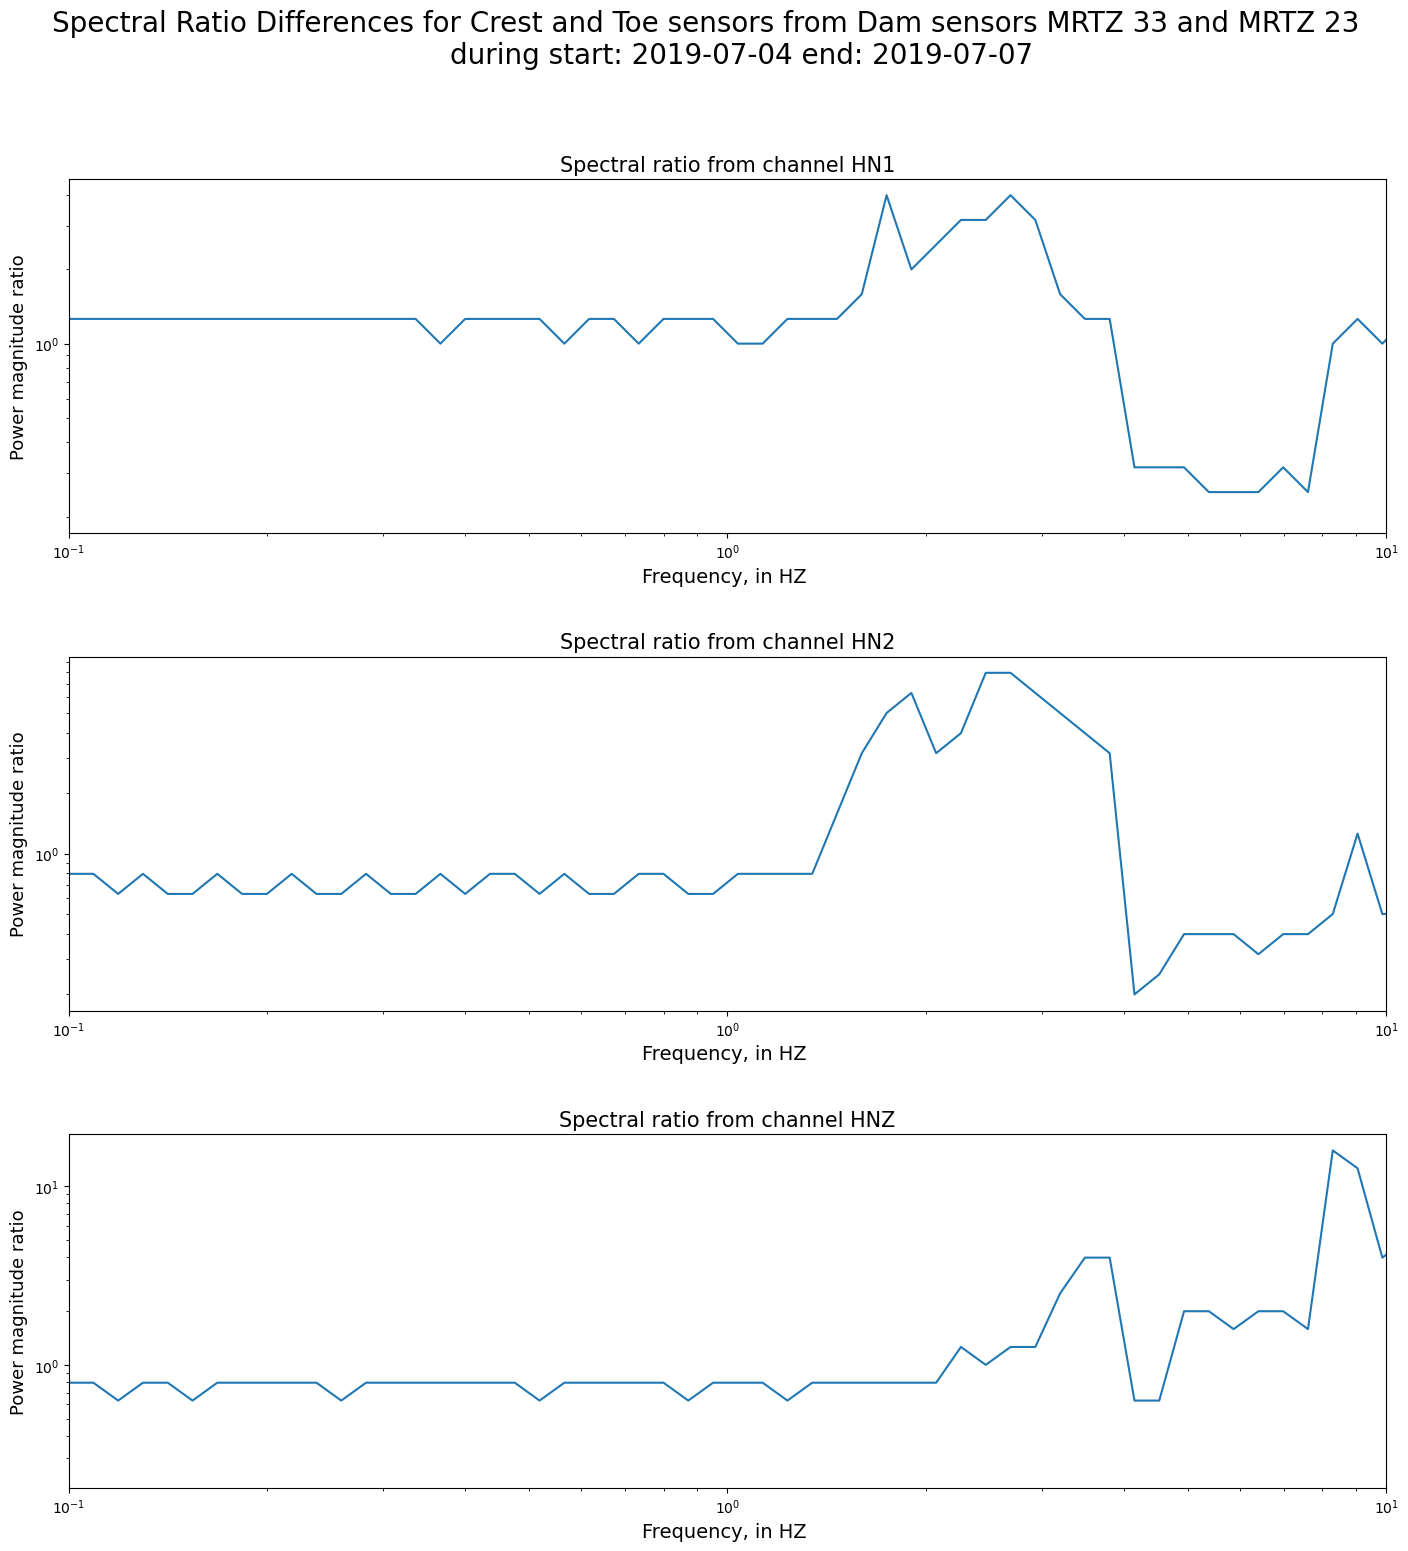

In [28]:
dicloc33,dicloc23,ratio = super_ratio_finder_loc_33_23()

## Ratio Finder that factors in unique frequencies and operates on location differentiation between 30 and 11

In [24]:
def super_ratio_finder_loc_30_11():
    
    def getPDF(Network,Station,location,channel,starttime,endtime):
        import requests

        NEWURL = f"""http://service.iris.edu/mustang/noise-pdf/1/query?net={Network}&sta={Station}&loc={location}&cha={channel}&quality=
        M&starttime={starttime}&endtime={endtime}&format=text&nodata=404"""

        response = requests.get(NEWURL)
        underscore = '_'
        if '*' in location:
            file = open(f'{Network+Station+channel+starttime+underscore+endtime}M', "wb")
            file.write(response.content)
            file.close()
        else:
            file = open(f'{Network+Station+location+channel+starttime+underscore+endtime}M', "wb")
            file.write(response.content)
            file.close()

        return file,starttime,endtime
    
    def file_request():
        Network = input('Please enter Dam network: ')
        Station = input('Please enter station ID (ex: EACA): ')
        location = input('Enter location ID: ')
        channel = input('Please enter Channel ID (ex: HH1): ')
        starttime = input('pplease enter the start date. Enter in yyyy-mm-dd format: ')
        endtime = input('Please enter the desired end date')
        file,starttime,endtime = getPDF(Network,Station,location,channel,starttime,endtime)
        return file,starttime,endtime

    def Mustang_text_reader(file = False,starttime = False, endtime = False):
        '''Text Files from the Mustang URL builder can be converted into pandas dataframes. However, they need to be edited
        first so that they can have the proper format for conversion. This function Takes care of the neccessary editing and
        returns a properly formatted dataframe'''
        import pandas as pd
        import os
        if file:
            old_file_name = file.name
            new_file_name = old_file_name+'new'
            with open(old_file_name) as old_file, open(new_file_name, 'w') as new_file:
            #Skip through the first four lines of the old text file, and write the remaining lines to a new txt 
                for i, line in enumerate(old_file):
                    if i < 4:
                        continue
                    #Write the remaining data lines to the new text file
                    new_file.write(line)
            #Open the newly written text file and read it in as a pandas dataframe. Title the index column with the start 
            #and end times.
            new_df = open(new_file_name)
            df = pd.read_csv(new_df)
            timestamp = 'start: '+starttime+' end: '+endtime
            df.index.name = timestamp
            import numpy as np
            unique_freq = pd.unique(df['#freq(hz)'])
            powers = np.array([])
            for freq in unique_freq:
                newest_df = df[df['#freq(hz)'] == freq]
                most_hits = newest_df.loc[newest_df[' hits'].idxmax()]
                powers = np.append(powers,most_hits[1])
            super_df = pd.DataFrame()
            super_df['#freq(hz)'] = unique_freq
            super_df[' power(db)'] = powers
            super_df.index.name = df.index.name
            #Close the new text file
            new_file.close()
            #Remove the old file
            os.remove(old_file_name)
            #Return the dataframe
            return(super_df,timestamp)
         
        elif file == False:
            #Make variables reprenting the inputted (old) filename by calling file request and the future (new) filename
            old_file_io,starttime,endtime = file_request()
            old_file_name = old_file_io.name
            new_file_name = old_file_name+'new'
            #Open the old and new files (opening the new is creating a new file)
            with os.open(old_file_name) as old_file, os.open(new_file_name, 'w') as new_file:
            #Skip through the first four lines of the old text file, and write the remaining lines to a new txt 
                for i, line in enumerate(old_file):
                    if i < 4:
                        continue
                    #Write the remaining data lines to the new text file
                    new_file.write(line)
            #Open the newly written text file and read it in as a pandas dataframe. Title the index column with the start 
            #and end times.
            new_df = open(new_file_name)
            df = pd.read_csv(new_df)
            timestamp = 'start: '+starttime+' end: '+endtime
            df.index.name = timestamp
            import numpy as np
            unique_freq = pd.unique(df['#freq(hz)'])
            powers = np.array([])
            for freq in unique_freq:
                newest_df = df[df['#freq(hz)'] == freq]
                most_hits = newest_df.loc[newest_df[' hits'].idxmax()]
                powers = np.append(powers,most_hits[1])
            super_df = pd.DataFrame()
            super_df['#freq(hz)'] = unique_freq
            super_df[' power(db)'] = powers
            super_df.index.name = df.index.name
            #Close the new text file
            new_file.close()
            os.remove(old_file_name)
            #Return the dataframe
            return(df,timestamp)
    def mustang_station_comparison_reader():
        loc = input('Please enter 1st station ID: ')
        start = input('Please enter first recording time: ')
        end = input('Please enter second recording time: ')
        dicloc30 = dict()
        dicloc11 = dict()
        for i in range(1,4):
            if i == 3:
                file,starttime,endtime = getPDF('RE',loc,'30','HNZ',start,end)
                df,timestamp = Mustang_text_reader(file,starttime,endtime)
                dicloc30['HNZ'] = (df,timestamp)
            else:
                file,starttime,endtime = getPDF('RE',loc,'30',f'HN{i}',start,end)
                df,timestamp = Mustang_text_reader(file,starttime,endtime)
                dicloc30[f'HN{i}'] = (df,timestamp)
        for i in range(1,4):
            if i == 3:
                file,starttime,endtime = getPDF('RE',loc,'11','HNZ',start,end)
                df,timestamp = Mustang_text_reader(file,starttime,endtime)
                dicloc11['HNZ'] = (df,timestamp)
            else:
                file,starttime,endtime = getPDF('RE',loc,'11',f'HN{i}',start,end)
                df,timestamp = Mustang_text_reader(file,starttime,endtime)
                dicloc11[f'HN{i}'] = (df,timestamp)
        return(dicloc30,dicloc11,loc,starttime,endtime)

    dicloc30,dicloc11,loc,starttime,endtime = mustang_station_comparison_reader()
    
    def spectral_ratio_finder(dicloc30,dicloc11):
        import numpy as np
        ratio_dic = dict()
        for channel in dicloc30:
            powerarrloc1 = np.array(dicloc30[channel][0][' power(db)'])
            powerarrloc2 = np.array(dicloc11[channel][0][' power(db)'])
            if len(powerarrloc1) < len(powerarrloc2):
                diff = len(powerarrloc2) - len(powerarrloc1)
                powerarrloc2 = powerarrloc2[0:len(powerarrloc2)-diff] 
            elif len(powerarrloc2) < len(powerarrloc1):
                diff = len(powerarrloc1) - len(powerarrloc2)
                powerarrloc1 = powerarrloc1[0:len(powerarrloc1)-diff] 
            pmag1 = (10**(powerarrloc1/10))
            pmag2 = (10**(powerarrloc2/10))
            ratio = pmag1/pmag2
            ratio_dic[channel] = (ratio,dicloc30[channel][0]['#freq(hz)'],dicloc30[channel][1])
        return(ratio_dic)

    ratio = spectral_ratio_finder(dicloc30,dicloc11) 
    
    def Mustang_ratio_plotter(ratio_dic,loc):
        import matplotlib.pyplot as plt
        fig,ax = plt.subplots(3,1, figsize = (17,17))
        plt.subplots_adjust(hspace=0.35)
        fig.suptitle(f"""Spectral Ratio Differences for Crest and Toe sensors from Dam sensors {loc} 30 and {loc} 11
        during {ratio_dic['HN1'][2]}""", fontsize = 20)
        axes = ax.flatten()
        for i, channel in enumerate(ratio_dic):
            freq = ratio_dic[channel][1]
            ratio = ratio_dic[channel][0]
            if len(freq) < len(ratio):
                diff = len(ratio) - len(freq)
                ratio = ratio[0:len(ratio) - diff]
            elif len(ratio) < len(freq):
                diff = len(freq) - len(ratio)
                freq = freq[0:len(freq) - diff]
            axes[i].plot(freq,ratio)
            axes[i].set_title(f'Spectral ratio from channel {channel}',fontsize = 15)
            axes[i].set_xlabel('Frequency, in HZ ',fontsize = 14)
            axes[i].set_ylabel('Power magnitude ratio',fontsize = 13)
            axes[i].set_xscale('log')
            axes[i].set_yscale('log')
            axes[i].set_xlim(0.1,10)
            
    Mustang_ratio_plotter(ratio,loc)
    
    for i in range(1,4):
        if i == 3:
            new_csv = pd.DataFrame()
            new_csv['frequency (hz)'] = ratio['HNZ'][1]
            new_csv['ratio'] = ratio['HNZ'][0]
            new_csv.to_csv(f"{loc}_{starttime}_{endtime}_channel_HNZ_ratio_data.csv")
        else:
            new_csv = pd.DataFrame()
            new_csv['frequency (hz)'] = ratio[f'HN{i}'][1]
            new_csv['ratio'] = ratio[f'HN{i}'][0]
            new_csv.to_csv(f'{loc}_{starttime}_{endtime}_channel_HN{i}_ratio_data.csv')
    
    return(dicloc30,dicloc11,ratio)

Please enter 1st station ID:  SNJT
Please enter first recording time:  2019-07-06
Please enter second recording time:  2019-07-07


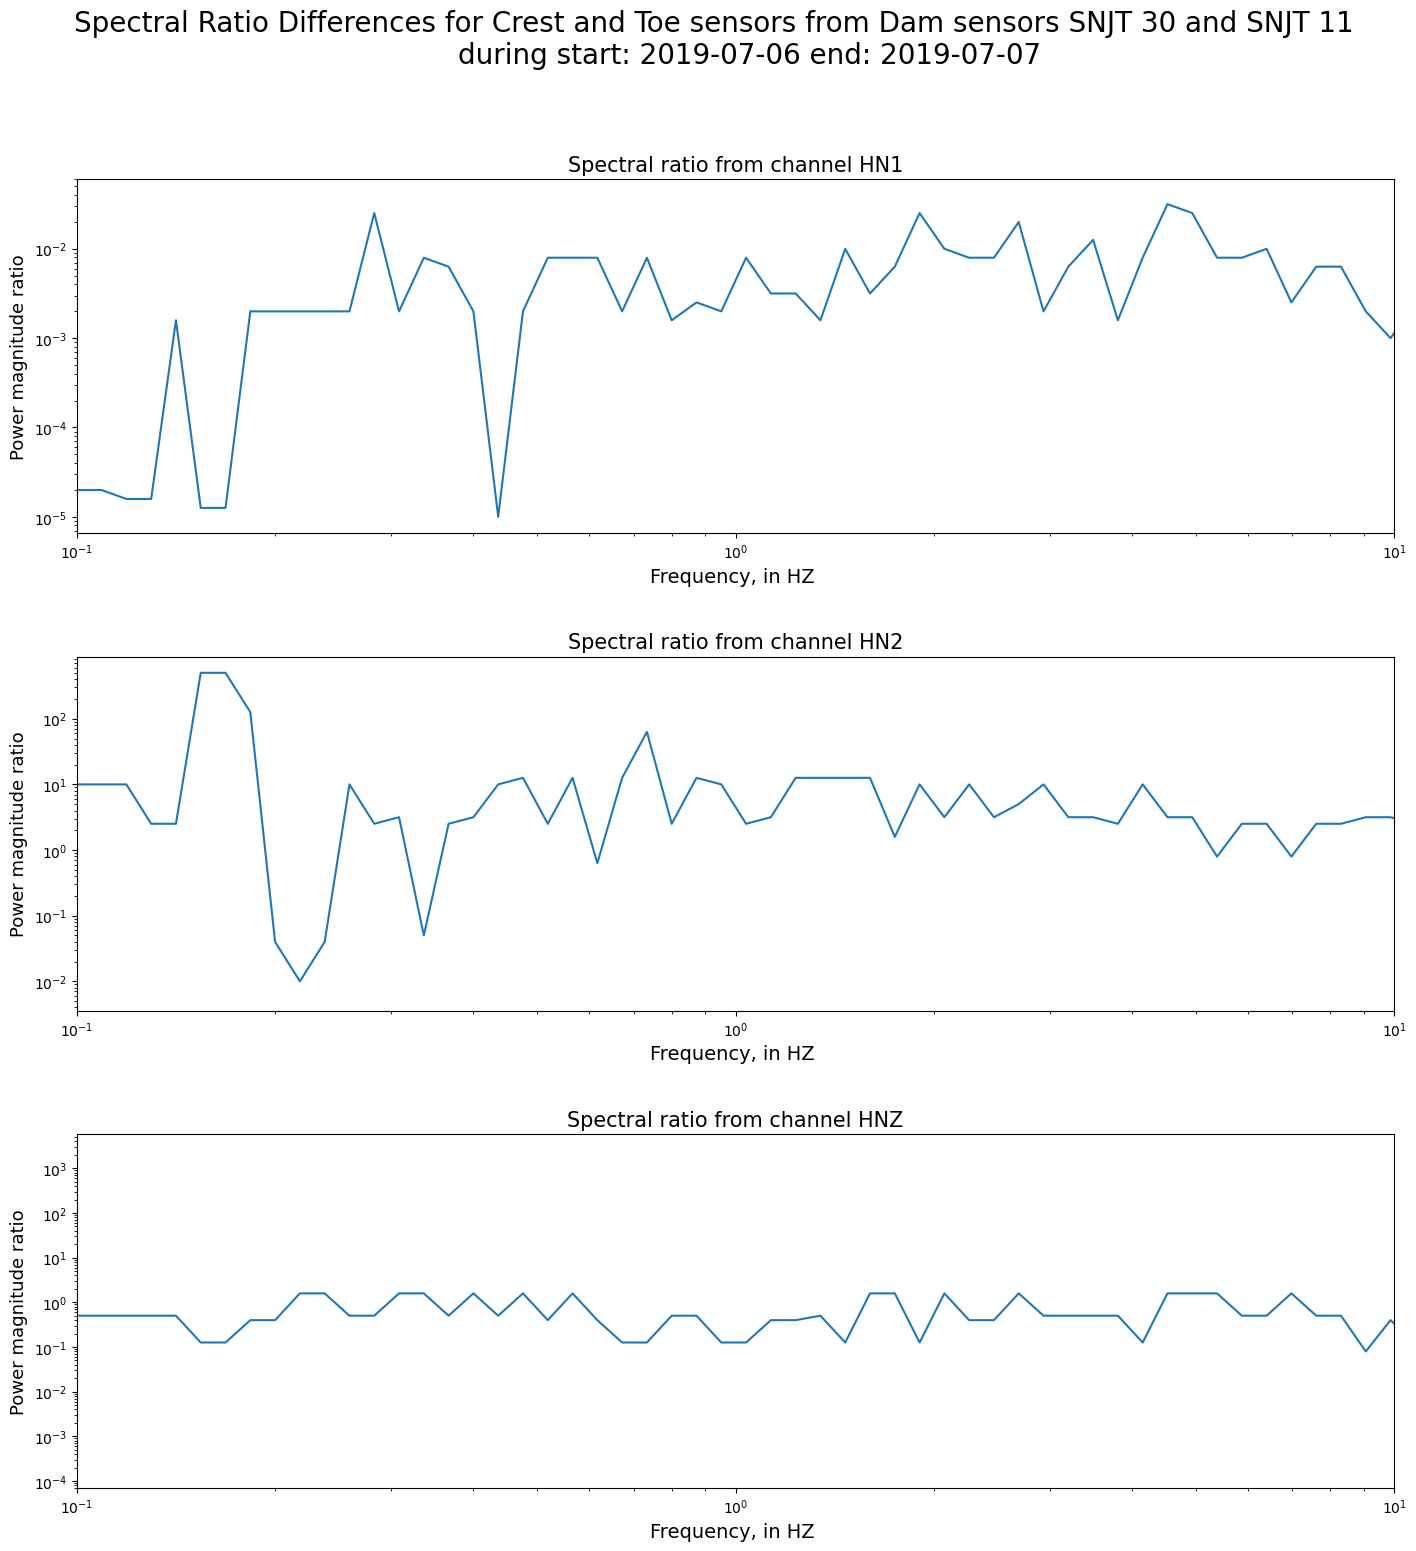

In [25]:
dicloc30,dicloc11,ratio = super_ratio_finder_loc_30_11()

# Swarm Sac file reading + Fourier Analysis

In [2]:
#Import Neccessary libraries
import obspy as ob
from obspy import read
from os import fsencode as fse
from os import fsdecode as fsd
from os import listdir as ld
from obspy.core import Trace,Stream
from obspy.signal.invsim import cosine_taper
import matplotlib.pyplot as plt
import numpy as np
from cmath import exp
import math
from matplotlib.ticker import ScalarFormatter
def abs2(x):
    return x.real**2 + x.imag**2
from numpy import float64
import pandas as pd


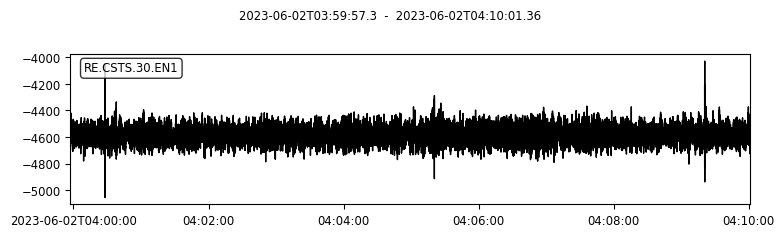

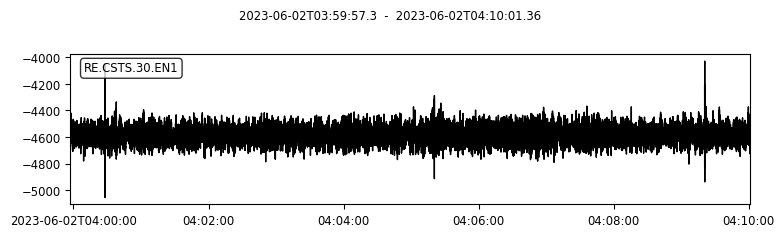

In [41]:
#Show an example plot of a SWARM .sac file 
st = read('Swarm_Sac_files/CSTS_EN1_RE_30.sac')
st.plot()

### This utility seperates the 1/2/Z channels of a given sensor on SWARM and calculates/plots the fourier transforms of each file within the group.

In [10]:
#Encode the file directory and list its contents
directory = fse('Swarm_Sac_files')
storage = ld(directory)
lst1 = []
lst2 = []
lstZ = []
# Loop through the content storage, decode its files and sort them into three different lists. 
for file in storage:
    file_name = fsd(file)
    word_list = file_name.split('_')
    word_id = word_list[1][2]
    if word_id == '1':
        lst1.append(file_name)
    elif word_id == '2':
        lst2.append(file_name)
    elif word_id == 'Z':
        lstZ.append(file_name)
lst1

['CSTS1_EN1_RE_20.sac', 'CSTS_EN1_RE_30.sac', 'CSTS_HN1_RE_35.sac']

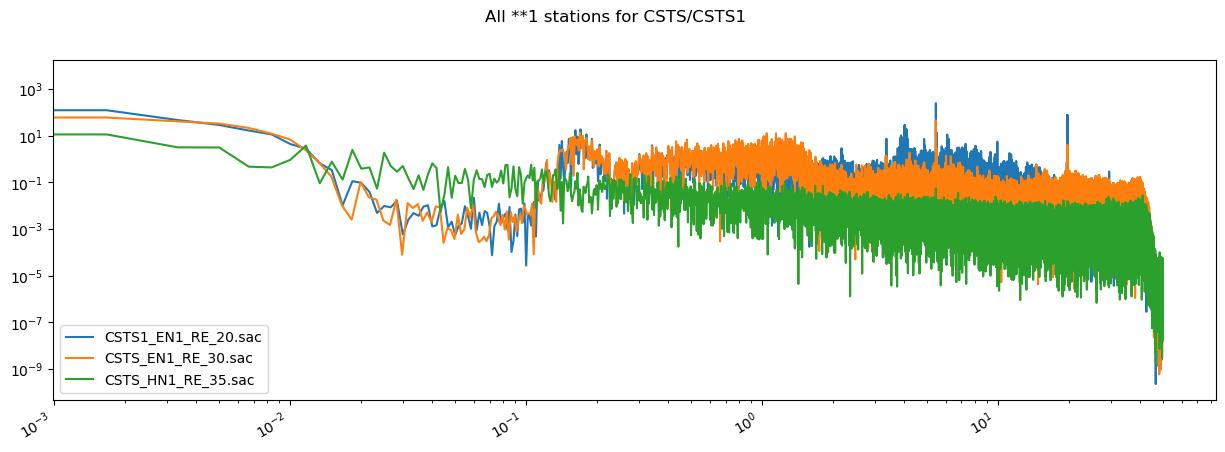

In [4]:
#Calcualte the Foureir transform of each .sac file and plot the results 
fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(1, 1, 1)
for data_file in lst1:
    st = read(f'Swarm_Sac_files/{data_file}')
    tr = st[0]
    tr.detrend('demean')
    tr.detrend('simple')
    tr.taper(type='cosine',max_percentage=0.1,side='both')
    tr_fft = np.fft.fft(tr.data)
    fft00= len(tr_fft)
    if fft00 % 2 == 0:
        fftn2 = int(fft00/2)
    else:
        fftn2 = int((fft00-1)/2)
    df = tr.stats.sampling_rate
    df2 = int(df/2)
    tr_fft = tr_fft[0:fftn2]
    freq_axis = np.linspace(0,df2,fftn2)
    scale = 2.0/((fft00-1)*(fft00-1))
    tr_psd = scale*abs2(tr_fft)
    freq_axis = float64(freq_axis)
    tr_psd = float64(tr_psd)
    ax.loglog(freq_axis,tr_psd)
    ax.xaxis_date()
    fig.autofmt_xdate()
plt.legend([lst1[0],lst1[1],lst1[2]])
fig.suptitle('All **1 stations for CSTS/CSTS1')
plt.show()
#Save the Fourier transform data in a csv file
df = pd.DataFrame()
df['freq_axis'] = np.array(freq_axis)
df['tr_psd'] = np.array(tr_psd)
df.to_csv('--1_stations_CSTS_CSTS1.csv')


Performance by EN stations is solid, yet the HN station (green) shows minimal response after 0.5 HZ. Its perforance is outdone by the EN stations

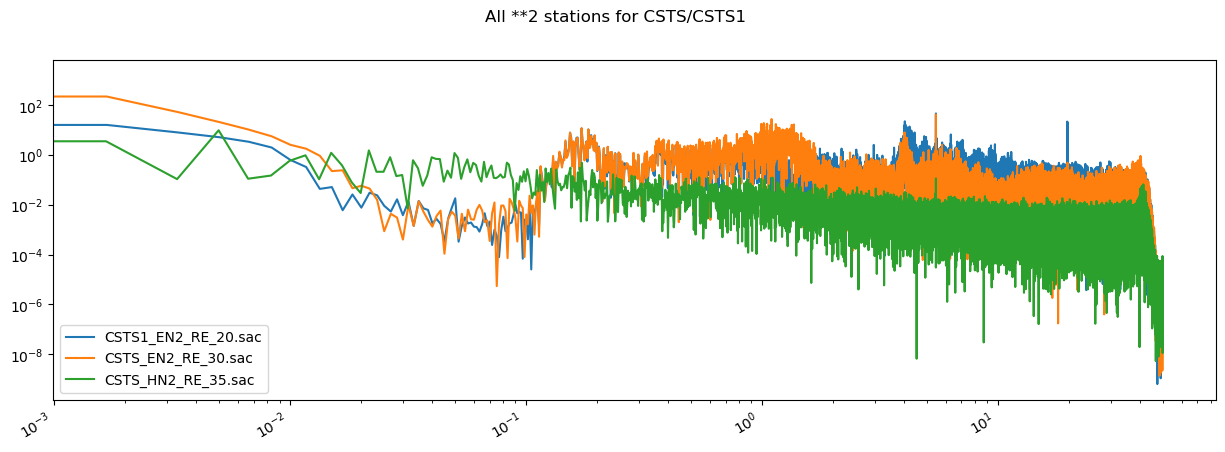

In [7]:
fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(1, 1, 1)
for data_file in lst2:
    st = read(f'Swarm_Sac_files/{data_file}')
    tr = st[0]
    tr.detrend('demean')
    tr.detrend('simple')
    tr.taper(type='cosine',max_percentage=0.1,side='both')
    tr_fft = np.fft.fft(tr.data)
    fft00= len(tr_fft)
    if fft00 % 2 == 0:
        fftn2 = int(fft00/2)
    else:
        fftn2 = int((fft00-1)/2)
    df = tr.stats.sampling_rate
    df2 = int(df/2)
    tr_fft = tr_fft[0:fftn2]
    freq_axis = np.linspace(0,df2,fftn2)
    scale = 2.0/((fft00-1)*(fft00-1))
    tr_psd = scale*abs2(tr_fft)
    freq_axis = float64(freq_axis)
    tr_psd = float64(tr_psd)
    ax.loglog(freq_axis,tr_psd)
    ax.xaxis_date()
    fig.autofmt_xdate()
plt.legend([lst2[0],lst2[1],lst2[2]])
fig.suptitle('All **2 stations for CSTS/CSTS1')
plt.show()
df = pd.DataFrame()
df['freq_axis'] = np.array(freq_axis)
df['tr_psd'] = np.array(tr_psd)
df.to_csv('--2_stations_CSTS_CSTS1.csv')

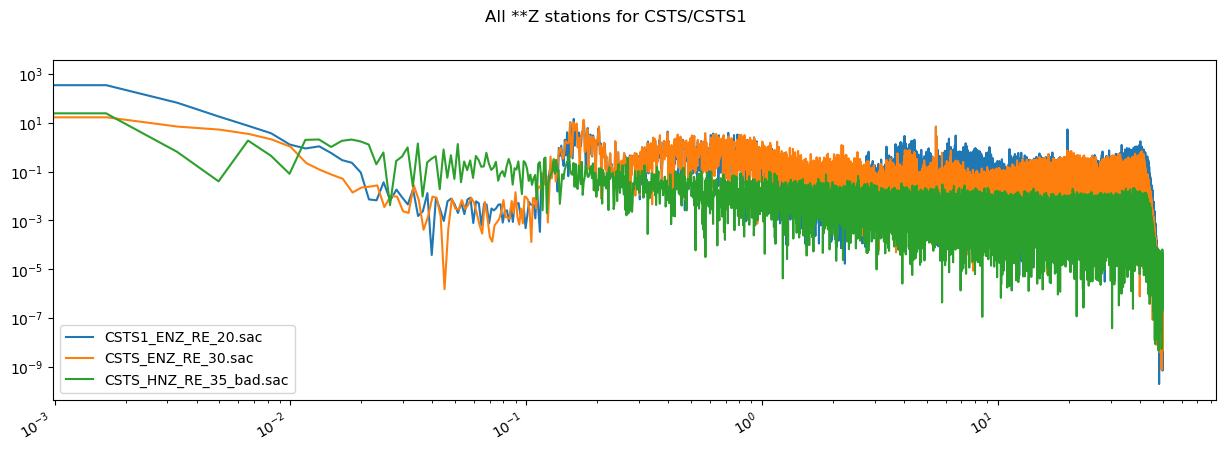

In [11]:
fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(1, 1, 1)
for data_file in lstZ:
    st = read(f'Swarm_Sac_files/{data_file}')
    tr = st[0]
    tr.detrend('demean')
    tr.detrend('simple')
    tr.taper(type='cosine',max_percentage=0.1,side='both')
    tr_fft = np.fft.fft(tr.data)
    fft00= len(tr_fft)
    if fft00 % 2 == 0:
        fftn2 = int(fft00/2)
    else:
        fftn2 = int((fft00-1)/2)
    df = tr.stats.sampling_rate
    df2 = int(df/2)
    tr_fft = tr_fft[0:fftn2]
    freq_axis = np.linspace(0,df2,fftn2)
    scale = 2.0/((fft00-1)*(fft00-1))
    tr_psd = scale*abs2(tr_fft)
    freq_axis = float64(freq_axis)
    tr_psd = float64(tr_psd)
    ax.loglog(freq_axis,tr_psd)
    ax.xaxis_date()
    fig.autofmt_xdate()
plt.legend([lstZ[0],lstZ[1],lstZ[2]])
fig.suptitle('All **Z stations for CSTS/CSTS1')
plt.show()
df = pd.DataFrame()
df['freq_axis'] = np.array(freq_axis)
df['tr_psd'] = np.array(tr_psd)
df.to_csv('--Z_stations_CSTS_CSTS.csv')

# XML File Reading Script

In [4]:
def XML_FILE_READER():
    #Define a funcion that will retrieve an xml file from an IRIS web request
    def getXML(Station,loc,channel,network):
        import requests
        #Define a URL for the web request which includes the inputted parameters
        NEWURL = f"""https://service.iris.edu/fdsnws/station/1/query?net={network}&sta={Station}&loc={loc}&cha={channel}&starttime=*&endtime=*&level=response&format=xml&nodata=404"""
        #Initiate the Web request, turn off SSL verification to prevent blockage from VPN software
        response = requests.get(NEWURL,verify = False)
        underscore = '_'
        #Wrtie the content of the web request to a new xml file. Close the file once it is written. 
        file = open(f'{network + underscore + Station+underscore+loc+underscore+channel}.xml', "wb")
        file.write(response.content)
        file.close()

        return file

    #Get the dam network from an input and generate an infinite loop that continually retrieves XML files. 
    network = input('Please enter Dam network: ')
    while True:    
        loc_list = []
        Station = input("Please Enter Station ID (EX: JRDN): ")
        #Generate an infinite loop that continually gets sensor locations for a given station until instructed otherwise. 
        while True:
            loc = input("Please Enter a sensor Location ID for collection (EX: 33): ")
            loc_list.append(loc)
            prompt = input('Would you like to stop inputting locations? (y/n):')
            if prompt == 'y':
                break

        #Get the sensor naming convention from an input. 
        channel = input("Please Enter Station sensor naming convention (EX: HN1,HNN,HH1,EN1,HNE)(ENTER THREE CHARACTERS!): ")

        #Loop through a range equivilent to the length of the location list.
        letter_list_NE = ['placeholder','N','E','Z']
        for j in range(0,len(loc_list)):
            for i in range(1,4):
                #Use the sensor naming convention to identify how to use the web request on a given channel. If the convention uses HNE, us the 
                # letter list to get all three sensor components through the web request. Or just use the loop variable i if the convention is HNZ. 
                if ((channel[2] == 'N' or channel[2]== 'E') or (channel[2]== 'n' or channel[2]== 'e')):
                    channel = channel[:2]
                    channel+=letter_list_NE[i]
                    getXML(Station,loc_list[j],channel,network)
                else:
                    if i == 3:
                        channel = channel[:2]
                        channel+='Z'
                        getXML(Station,loc_list[j],channel,network)
                    else:
                        channel = channel[:2]
                        channel+=str(i)
                        getXML(Station,loc_list[j],channel,network)
        prompt = input('Would you like to stop collecting XML files?(y/n): ')
        if prompt == 'y':
            break
            
            
            
    

XML_FILE_READER() 
